In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the data

train = pd.read_csv('train_hr.csv')

In [3]:
pandas_profiling.ProfileReport(train)

Number of variables,14
Number of observations,54808
Total Missing (%),0.9%
Total size in memory,5.9 MiB
Average record size in memory,112.0 B
Numeric,6
Categorical,5
Boolean,3
Date,0
Text (Unique),0
Rejected,0


In [4]:
train.corr()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,1.000000,-0.005121,0.000437,0.004533,0.001274,-0.002501,0.008420,-0.000586,0.001206
no_of_trainings,-0.005121,1.000000,-0.081278,-0.063126,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,0.000437,-0.081278,1.000000,0.006008,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
previous_year_rating,0.004533,-0.063126,0.006008,1.000000,0.000253,0.351578,0.027738,0.075139,0.159320
length_of_service,0.001274,-0.057275,0.657111,0.000253,1.000000,-0.077693,-0.039927,-0.038122,-0.010670
KPIs_met >80%,-0.002501,-0.045576,-0.025592,0.351578,-0.077693,1.000000,0.097000,0.078391,0.221582
awards_won?,0.008420,-0.007628,-0.008169,0.027738,-0.039927,0.097000,1.000000,0.072138,0.195871
avg_training_score,-0.000586,0.042517,-0.048380,0.075139,-0.038122,0.078391,0.072138,1.000000,0.181147
is_promoted,0.001206,-0.024896,-0.017166,0.159320,-0.010670,0.221582,0.195871,0.181147,1.000000


In [5]:
# getting their shapes
print("Shape of train:", train.shape)

Shape of train: (54808, 14)


In [6]:
print(train.head())

   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1 

In [7]:
# describing the training set

print(train.describe())

print(train.info())

        employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min    

In [8]:
# checking if there is any NULL value in the dataset

print(train.isnull().any())

employee_id             False
department              False
region                  False
education                True
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating     True
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
is_promoted             False
dtype: bool


Checking number of unique values in each column, just to confirm if there are multiple values in it.

In [9]:
#uni-varaiate Data Visualization
# checkig the no. of Employees Promoted

print(train['is_promoted'].value_counts())

0    50140
1     4668
Name: is_promoted, dtype: int64


In [10]:
# finding the %age of people promoted

promoted = (4668/54808)*100
print("Percentage of Promoted Employees is {:.2f}%".format(promoted))

Percentage of Promoted Employees is 8.52%


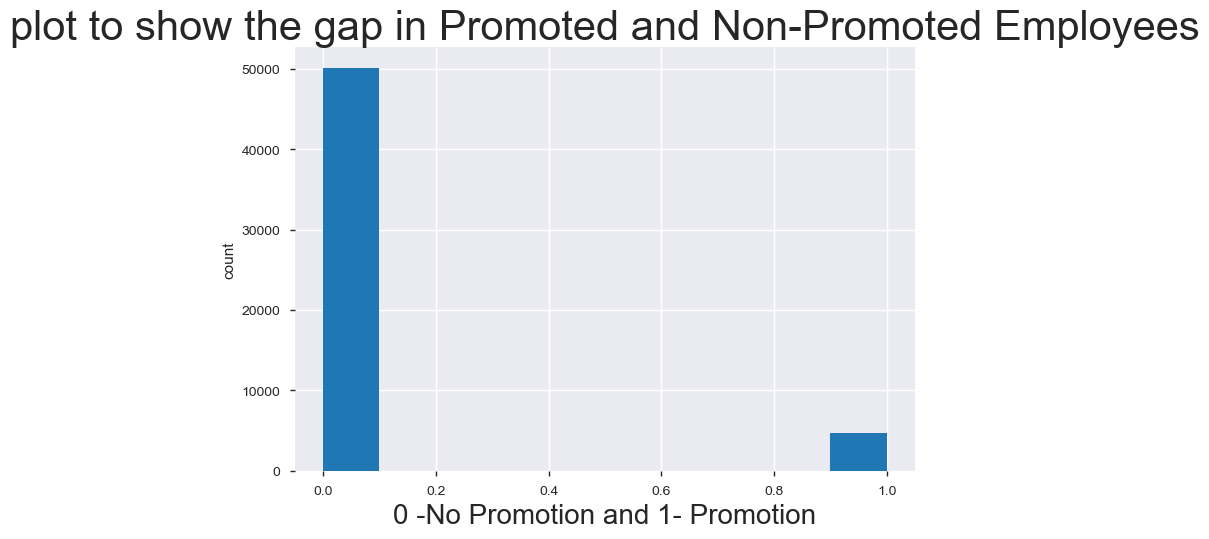

In [11]:
#plotting a scatter plot 

plt.hist(train['is_promoted'])
plt.title('plot to show the gap in Promoted and Non-Promoted Employees', fontsize = 30)
plt.xlabel('0 -No Promotion and 1- Promotion', fontsize = 20)
plt.ylabel('count')
plt.show()

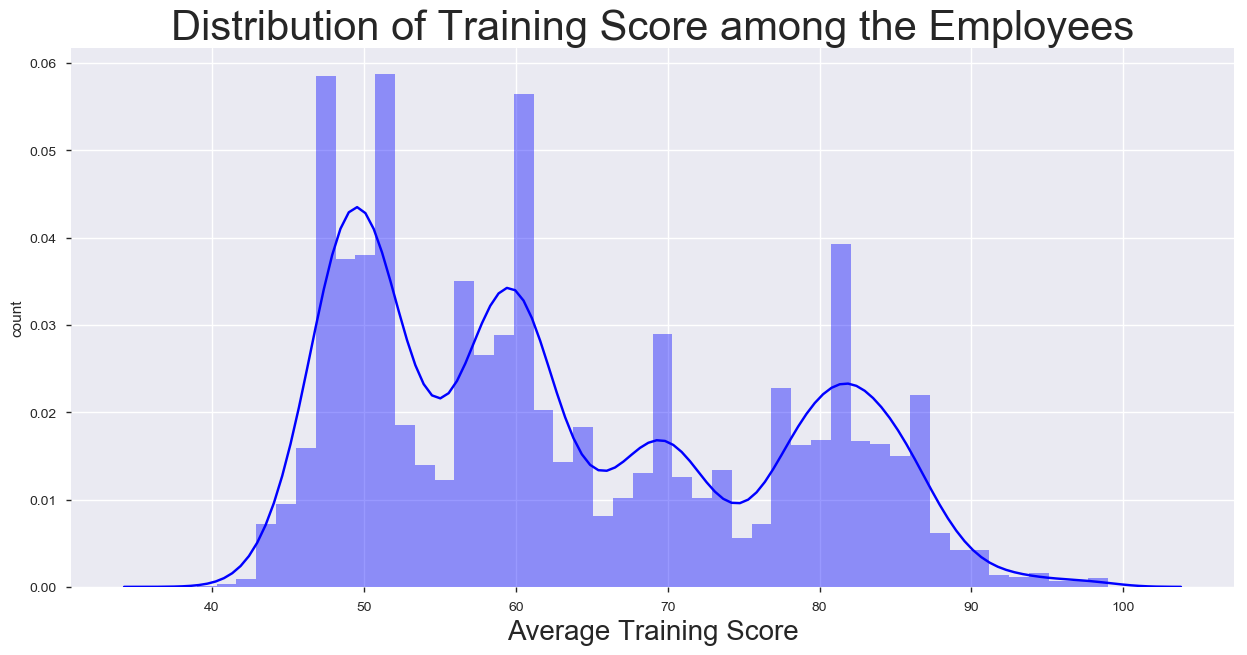

In [12]:
# checking the distribution of the avg_training score of the Employees

plt.rcParams['figure.figsize'] = (15, 7)
sns.distplot(train['avg_training_score'], color = 'blue')
plt.title('Distribution of Training Score among the Employees', fontsize = 30)
plt.xlabel('Average Training Score', fontsize = 20)
plt.ylabel('count')
plt.show()

In [13]:
print(train['awards_won?'].value_counts())

0    53538
1     1270
Name: awards_won?, dtype: int64


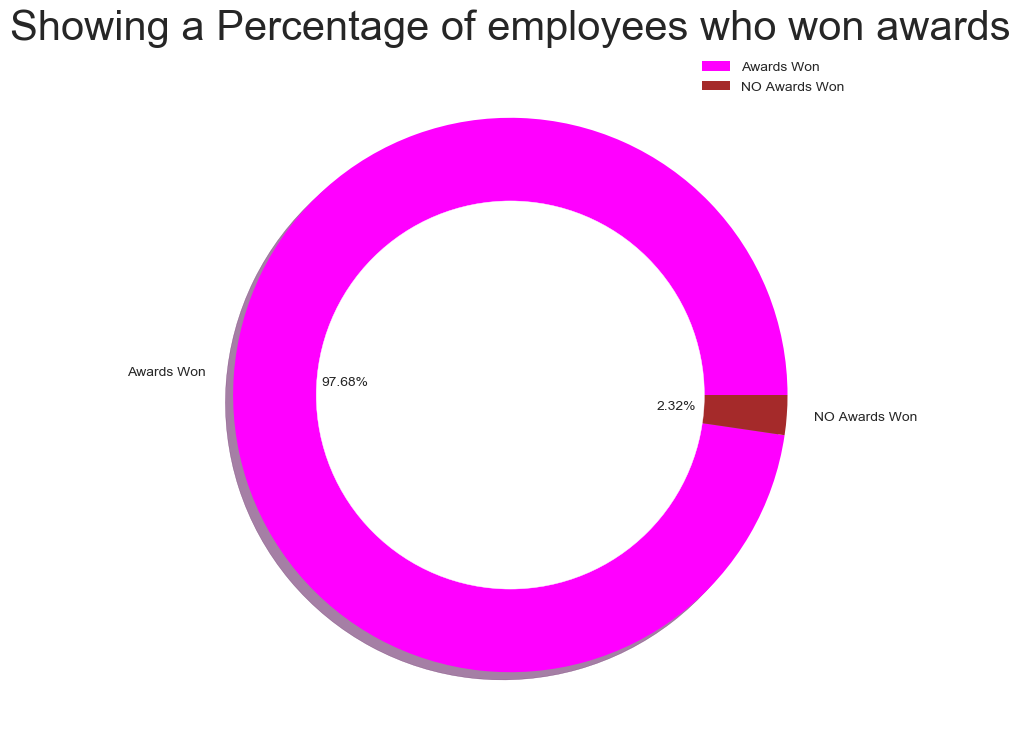

In [14]:
# plotting a donut chart for visualizing each of the recruitment channel's share

size = [53538, 1270]
colors = ['magenta', 'brown']
labels = "Awards Won", "NO Awards Won"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Showing a Percentage of employees who won awards', fontsize = 30)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend()
plt.show()

In [15]:
print(train['KPIs_met >80%'].value_counts())

0    35517
1    19291
Name: KPIs_met >80%, dtype: int64


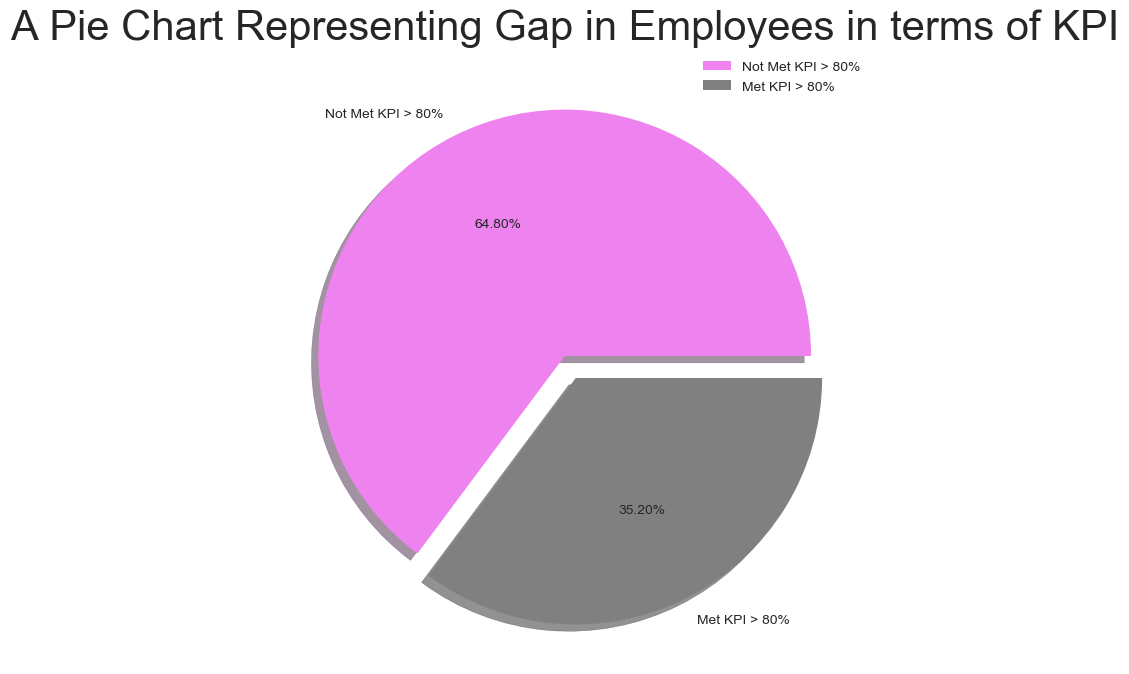

In [16]:
# plotting a pie chart

size = [35517, 19291]
labels = "Not Met KPI > 80%", "Met KPI > 80%"
colors = ['violet', 'grey']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('A Pie Chart Representing Gap in Employees in terms of KPI', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()

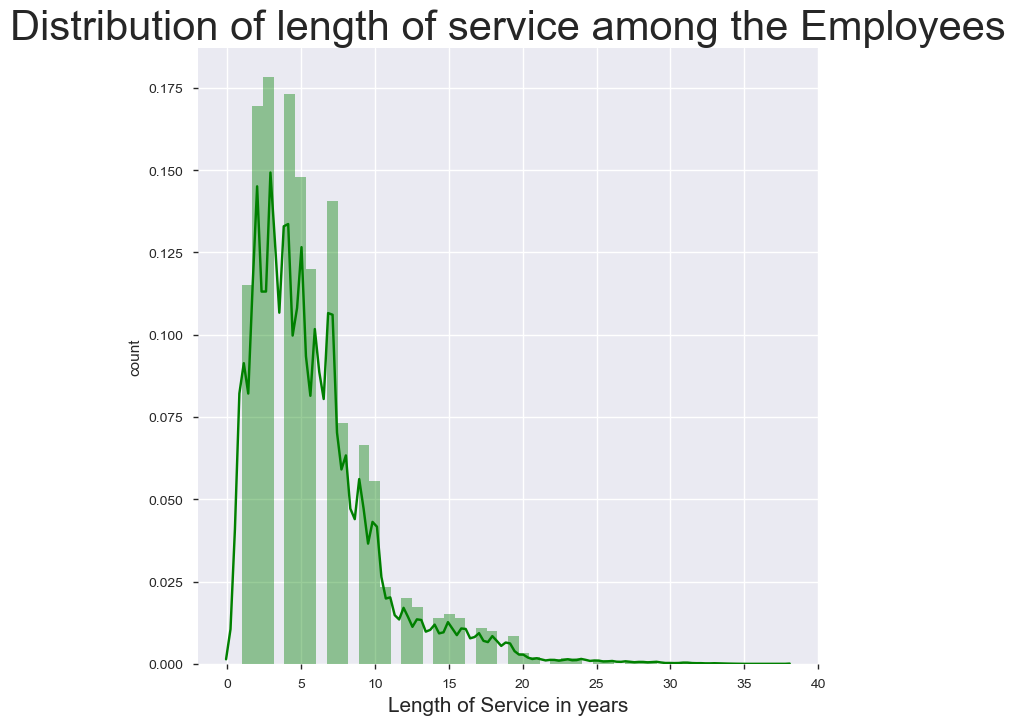

In [17]:
# checking the distribution of length of service

sns.distplot(train['length_of_service'], color = 'green')
plt.title('Distribution of length of service among the Employees', fontsize = 30)
plt.xlabel('Length of Service in years', fontsize = 15)
plt.ylabel('count')
plt.show()

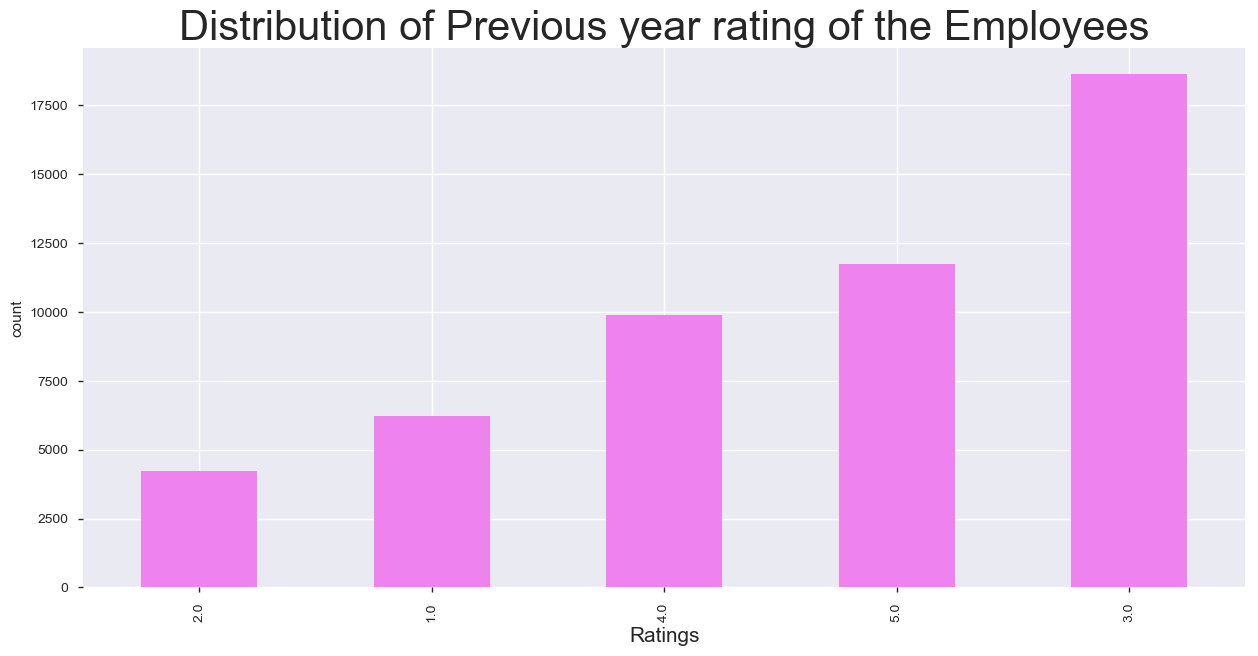

In [18]:
train['previous_year_rating'].value_counts().sort_values().plot.bar(color = 'violet', figsize = (15, 7))
plt.title('Distribution of Previous year rating of the Employees', fontsize = 30)
plt.xlabel('Ratings', fontsize = 15)
plt.ylabel('count')
plt.show()

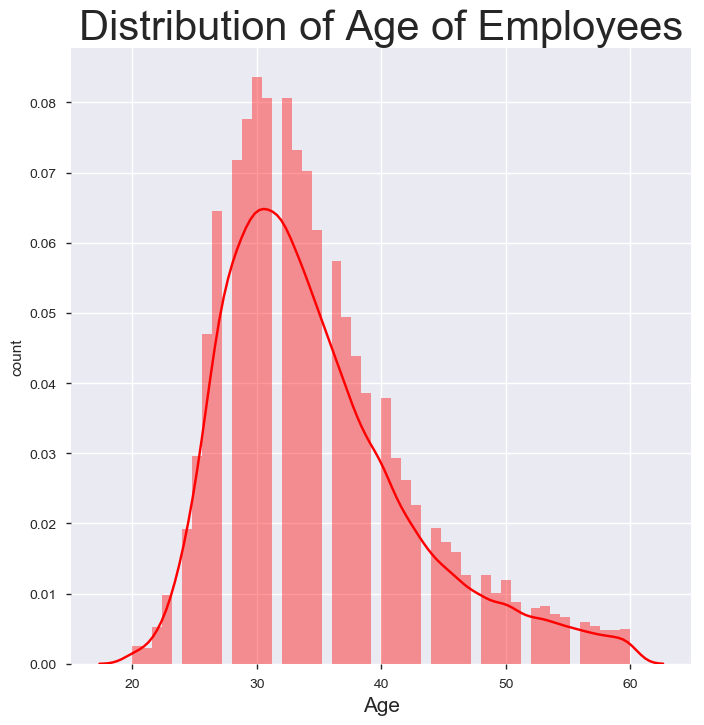

In [19]:
# checking the distribution of age of Employees in the company

sns.distplot(train['age'], color = 'red')
plt.title('Distribution of Age of Employees', fontsize = 30)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('count')
plt.show()

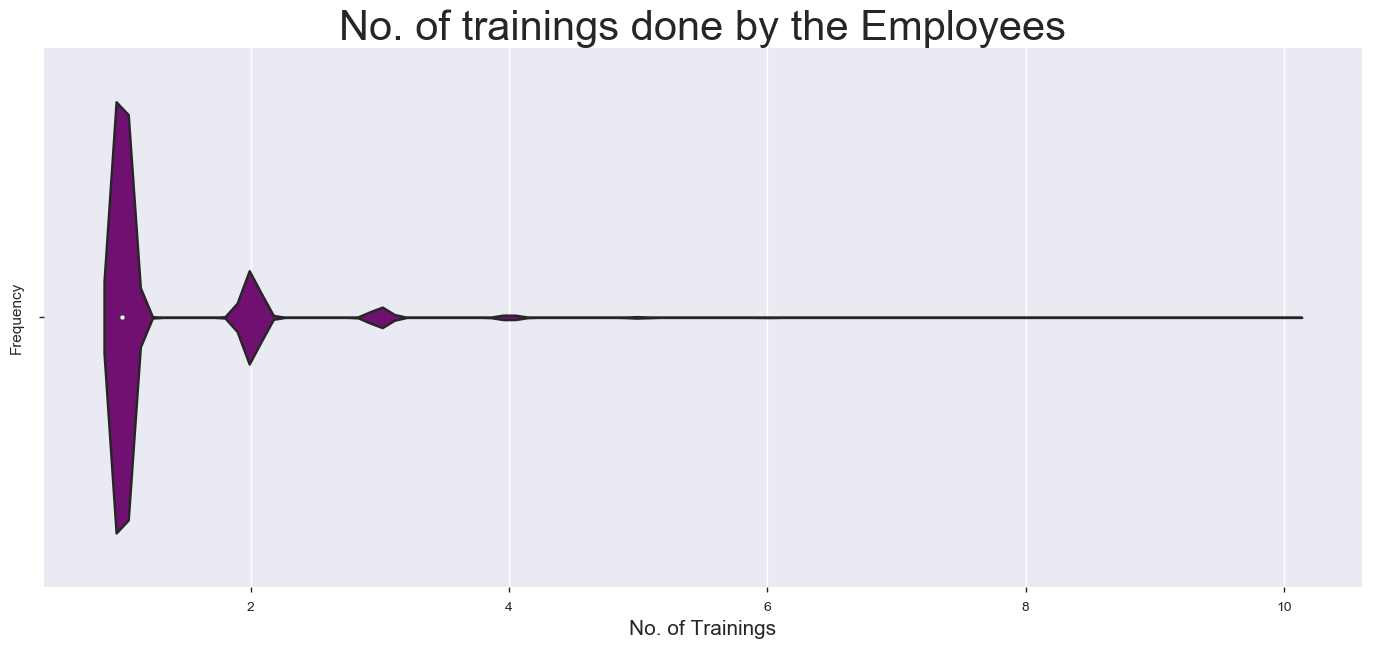

In [20]:
# checking the different no. of training done by the employees

plt.rcParams['figure.figsize'] = (17, 7)
sns.violinplot(train['no_of_trainings'], color = 'purple')
plt.title('No. of trainings done by the Employees', fontsize = 30)
plt.xlabel('No. of Trainings', fontsize = 15)
plt.ylabel('Frequency')
plt.show()

In [21]:
# checking the different types of recruitment channels for the company

train['recruitment_channel'].value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

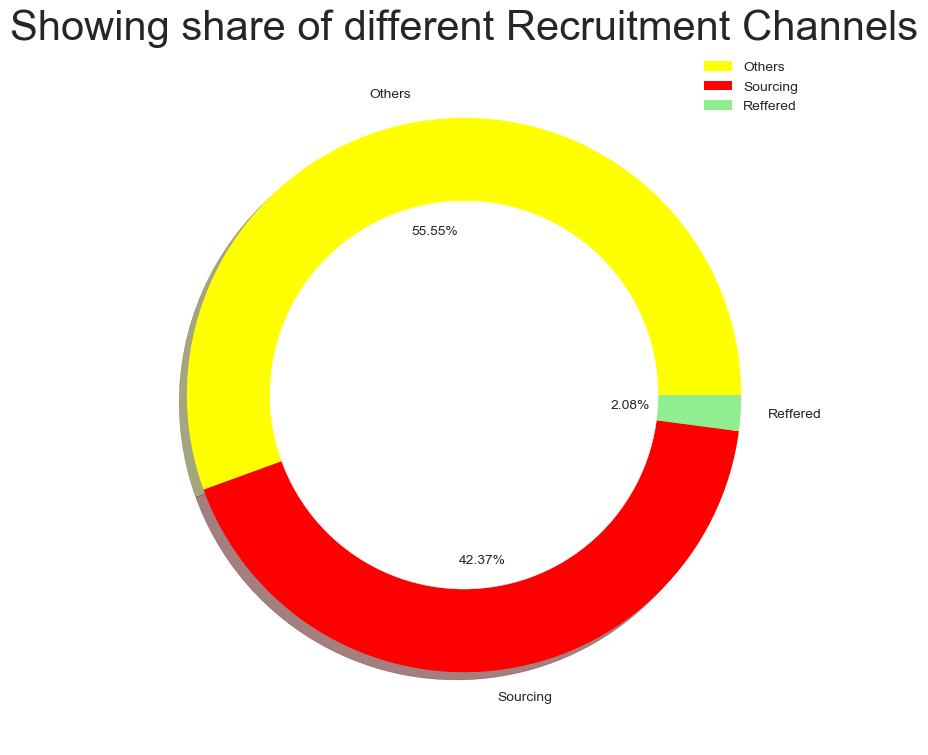

In [22]:
# plotting a donut chart for visualizing each of the recruitment channel's share

size = [30446, 23220, 1142]
colors = ['yellow', 'red', 'lightgreen']
labels = "Others", "Sourcing", "Reffered"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Showing share of different Recruitment Channels', fontsize = 30)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend()
plt.show()

In [23]:
# checking the gender gap

train['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

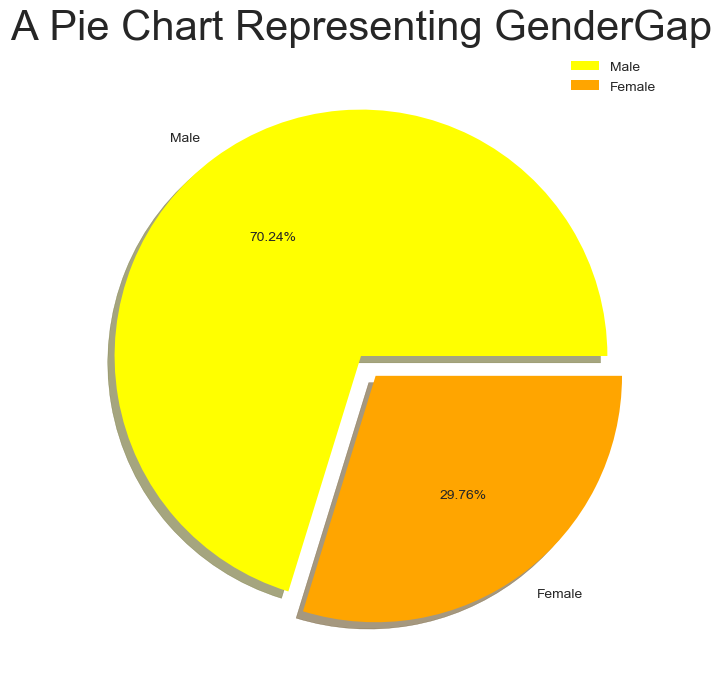

In [24]:
# plotting a pie chart

size = [38496, 16312]
labels = "Male", "Female"
colors = ['yellow', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('A Pie Chart Representing GenderGap', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()

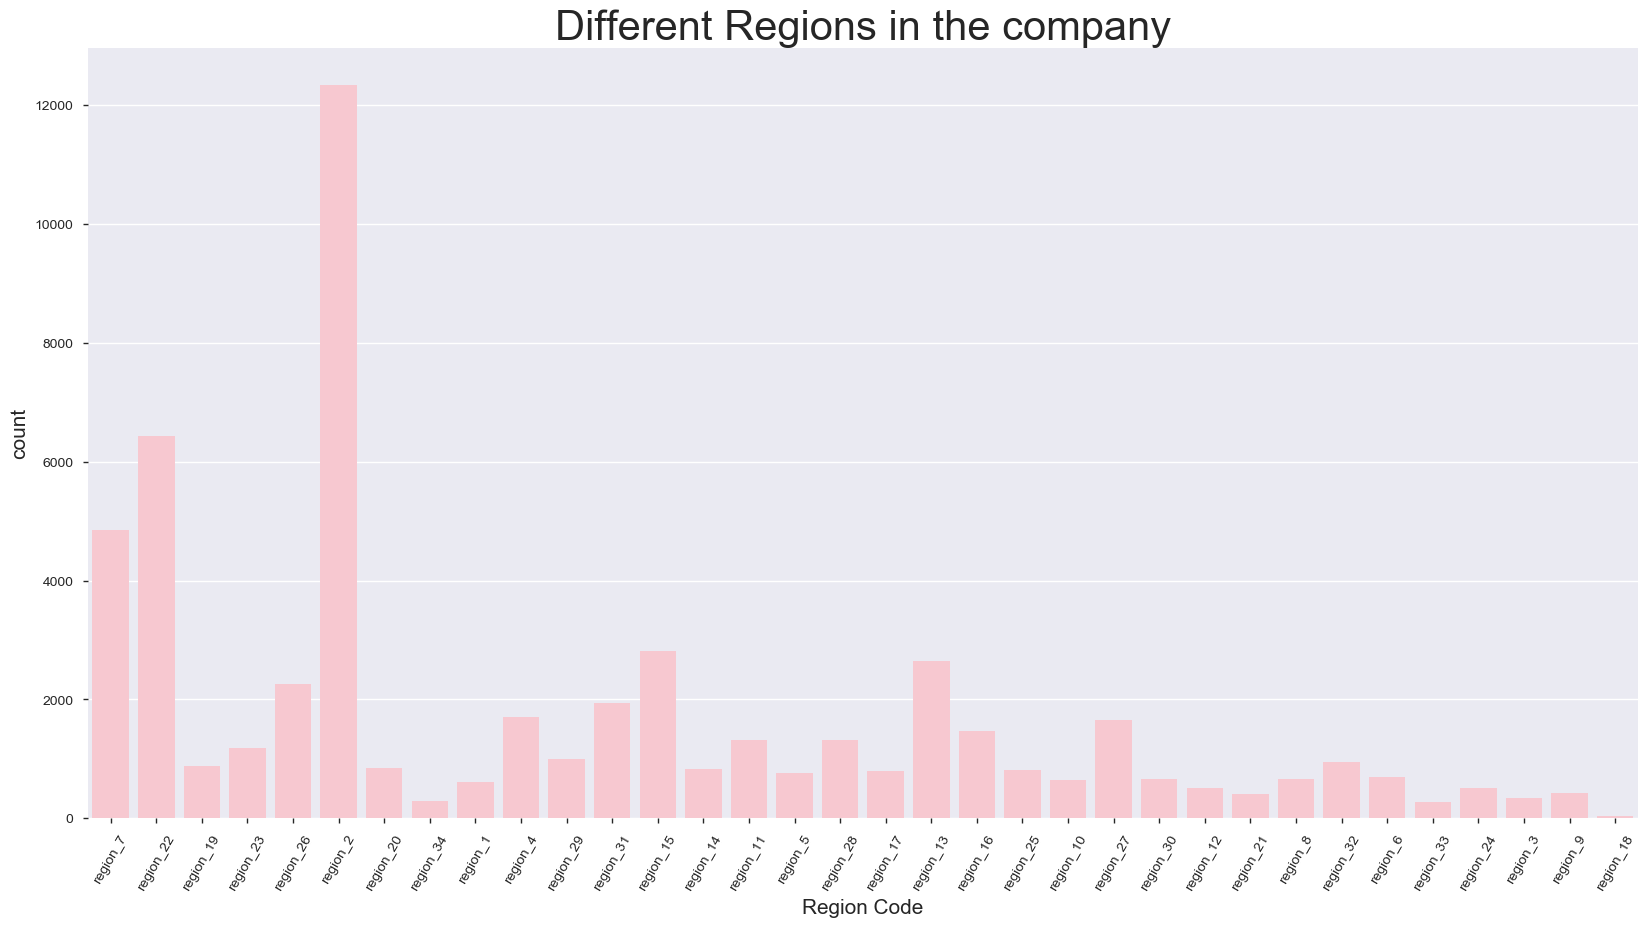

In [25]:
# checking the different regions of the company

plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(train['region'], color = 'pink')
plt.title('Different Regions in the company', fontsize = 30)
plt.xticks(rotation = 60)
plt.xlabel('Region Code', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.show()

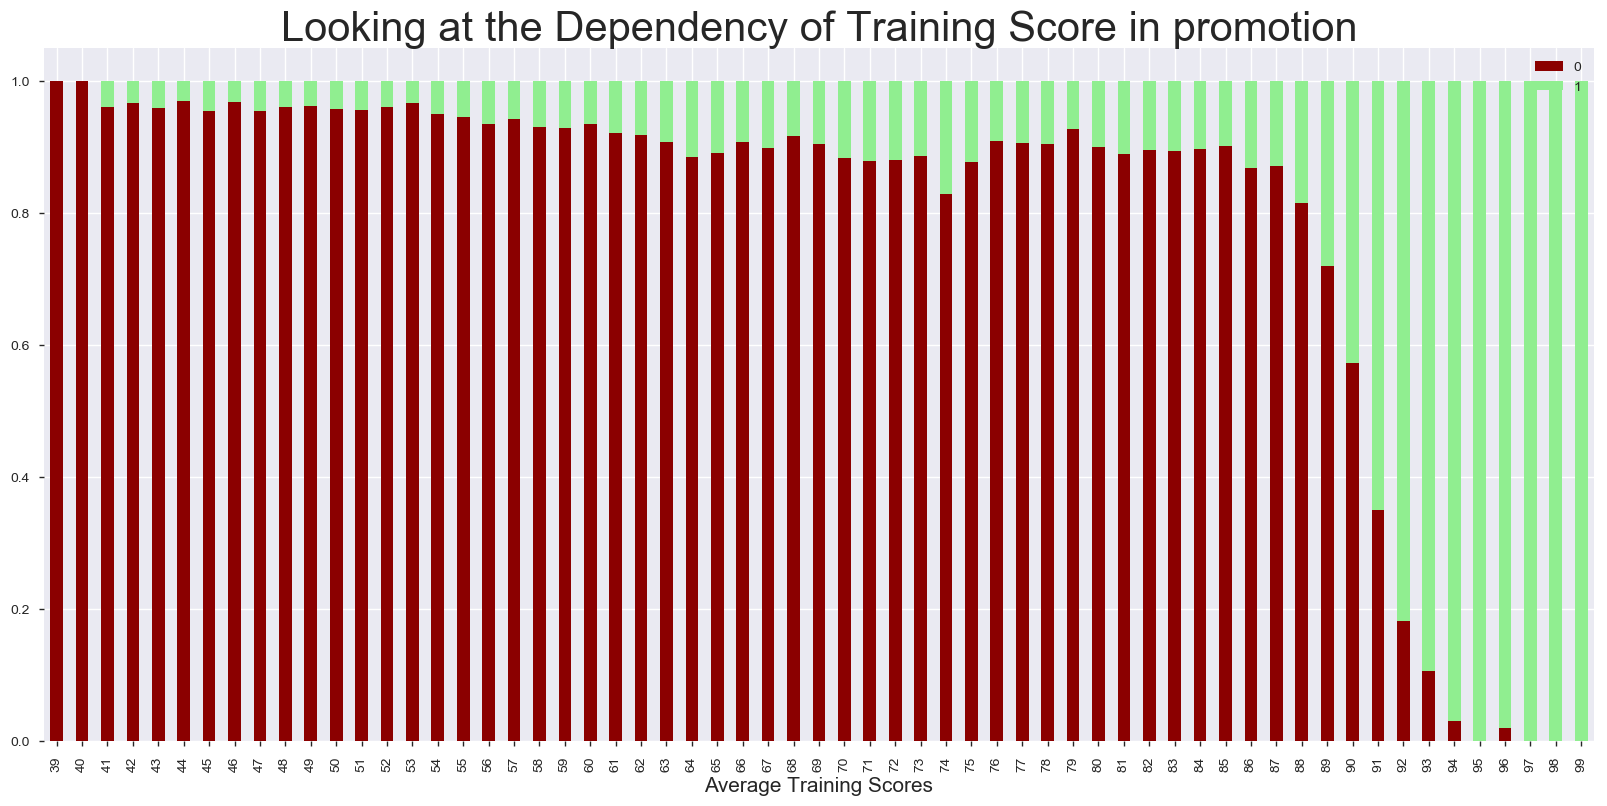

In [26]:
#Bi-varaiate Data Visualization
# scatter plot between average training score and is_promoted

data = pd.crosstab(train['avg_training_score'], train['is_promoted'])
data.div(data.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (20, 9), color = ['darkred', 'lightgreen'])

plt.title('Looking at the Dependency of Training Score in promotion', fontsize = 30)
plt.xlabel('Average Training Scores', fontsize = 15)
plt.legend()
plt.show()

As, the Training Scores Increases, the chances of Promotion Increases Highly

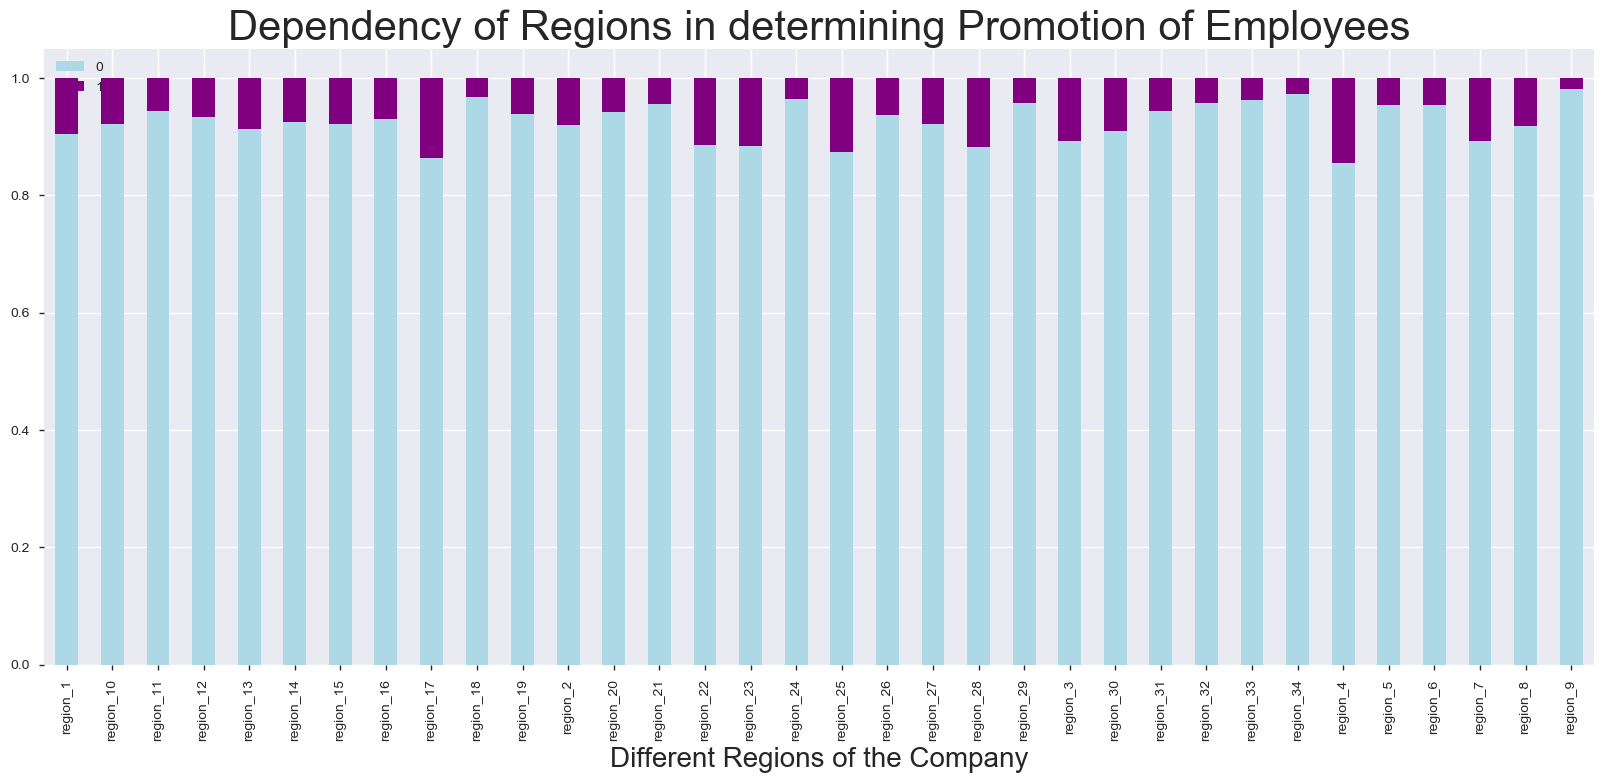

In [27]:
# checking dependency of different regions in promotion

data = pd.crosstab(train['region'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (20, 8), color = ['lightblue', 'purple'])

plt.title('Dependency of Regions in determining Promotion of Employees', fontsize = 30)
plt.xlabel('Different Regions of the Company', fontsize = 20)
plt.legend()
plt.show()

The above graph shows that there is no biasedness over regions in terms of Promotion as all the regions share promotions almost equally.

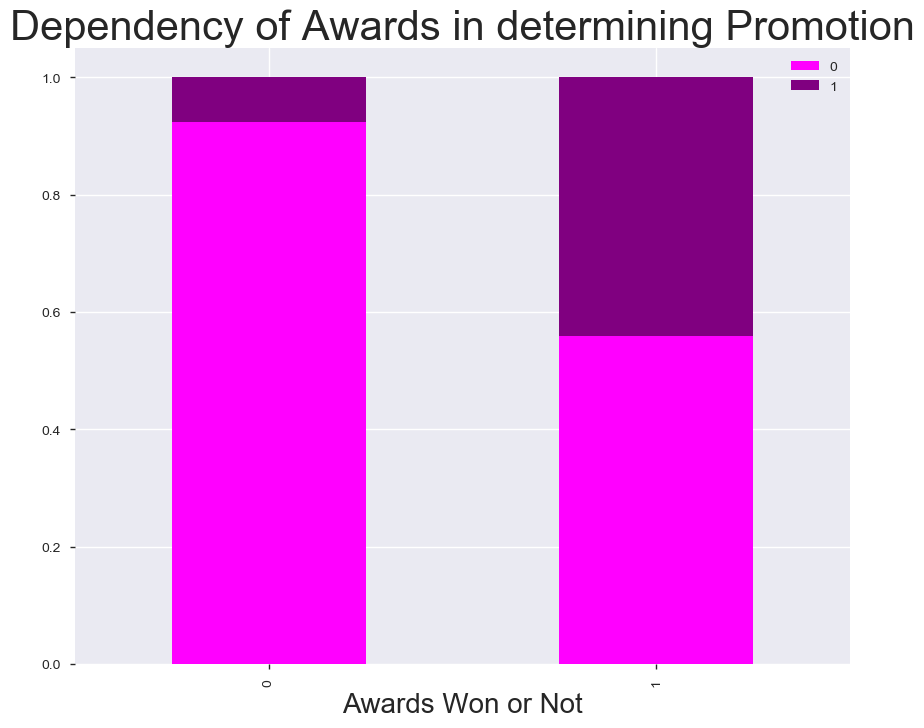

In [28]:
# dependency of awards won on promotion

data = pd.crosstab(train['awards_won?'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (10, 8), color = ['magenta', 'purple'])

plt.title('Dependency of Awards in determining Promotion', fontsize = 30)
plt.xlabel('Awards Won or Not', fontsize = 20)
plt.legend()
plt.show()

There is a very good chance of getting promoted if the employee has won an award

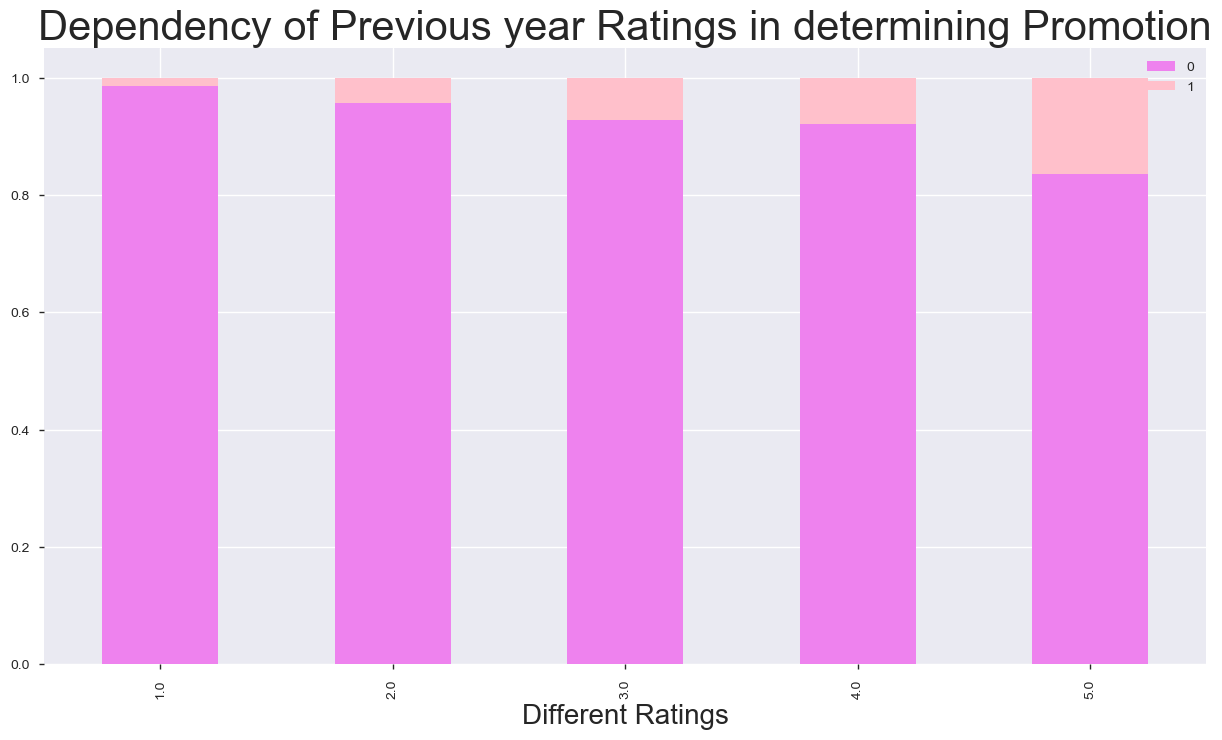

In [29]:
# checking dependency on previous years' ratings

data = pd.crosstab(train['previous_year_rating'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 8), color = ['violet', 'pink'])

plt.title('Dependency of Previous year Ratings in determining Promotion', fontsize = 30)
plt.xlabel('Different Ratings', fontsize = 20)
plt.legend()
plt.show()

The Above Graph clearly suggests that previous ratings matter a lot, if the ratings are high, the chances of being promoted in the company increases and there is completely no promotion for the employees with previous year ratings = 0

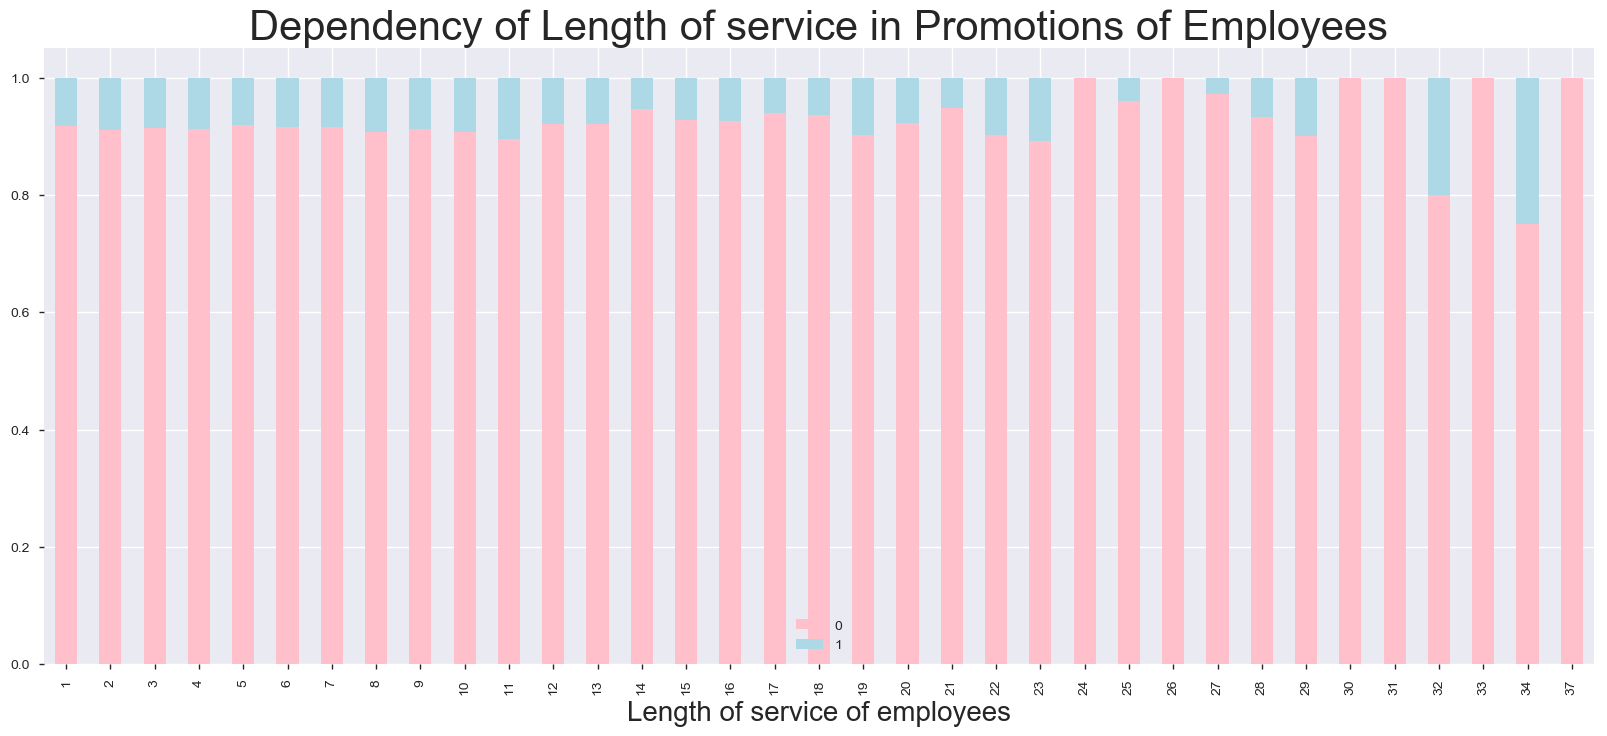

In [30]:
#checking how length of service determines the promotion of employees

data = pd.crosstab(train['length_of_service'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (20, 8), color = ['pink', 'lightblue'])

plt.title('Dependency of Length of service in Promotions of Employees', fontsize = 30)
plt.xlabel('Length of service of employees', fontsize = 20)
plt.legend()
plt.show()

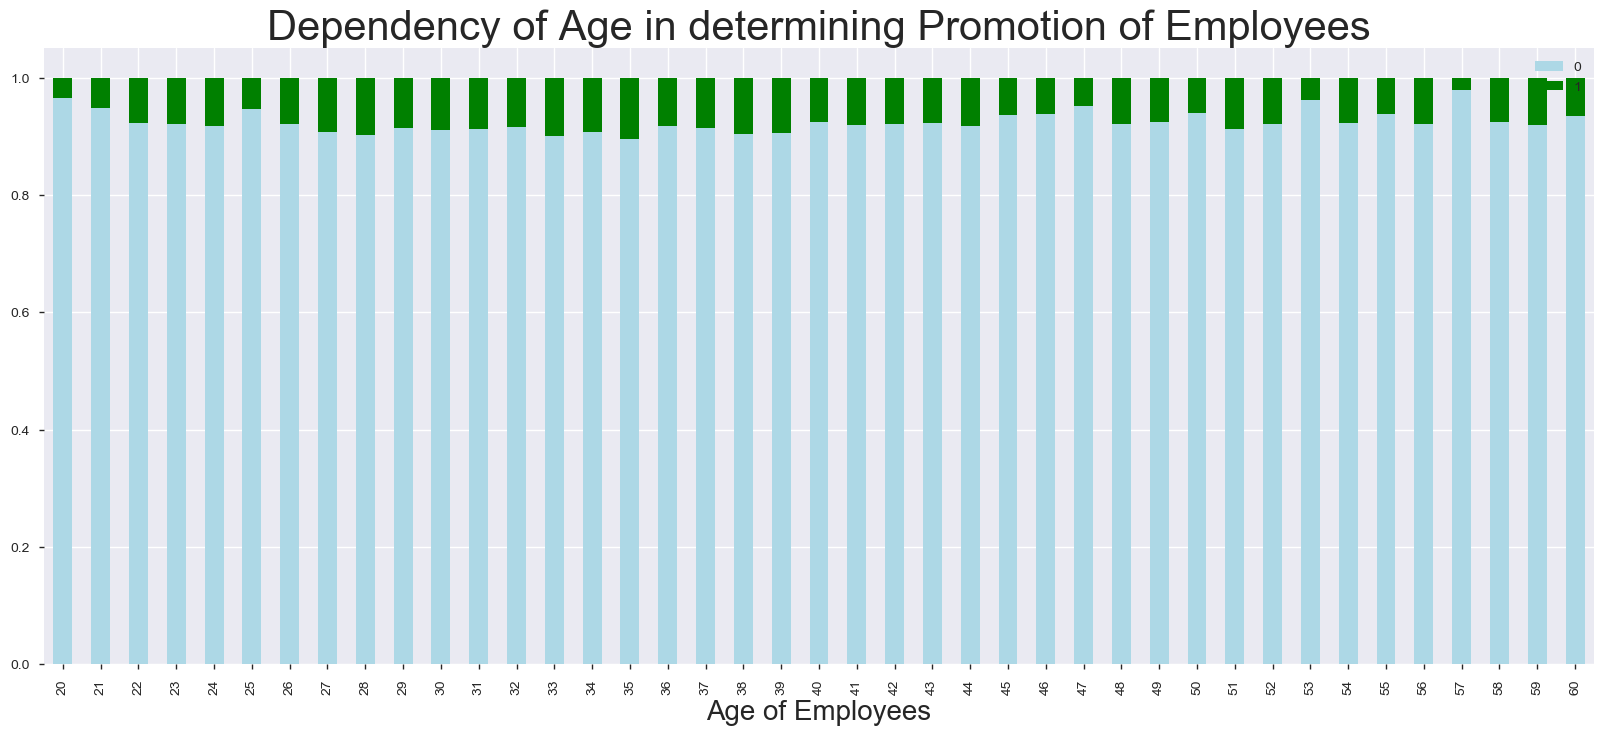

In [31]:
# checking dependency of age factor in promotion of employees

data = pd.crosstab(train['age'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (20, 8), color = ['lightblue', 'green'])

plt.title('Dependency of Age in determining Promotion of Employees', fontsize = 30)
plt.xlabel('Age of Employees', fontsize = 20)
plt.legend()
plt.show()

This is Very Impressive that the company promotes employees of all the ages equally even the freshers have equal share of promotion and also the senior citizen employees are getting the equal share of Promotion in the Company

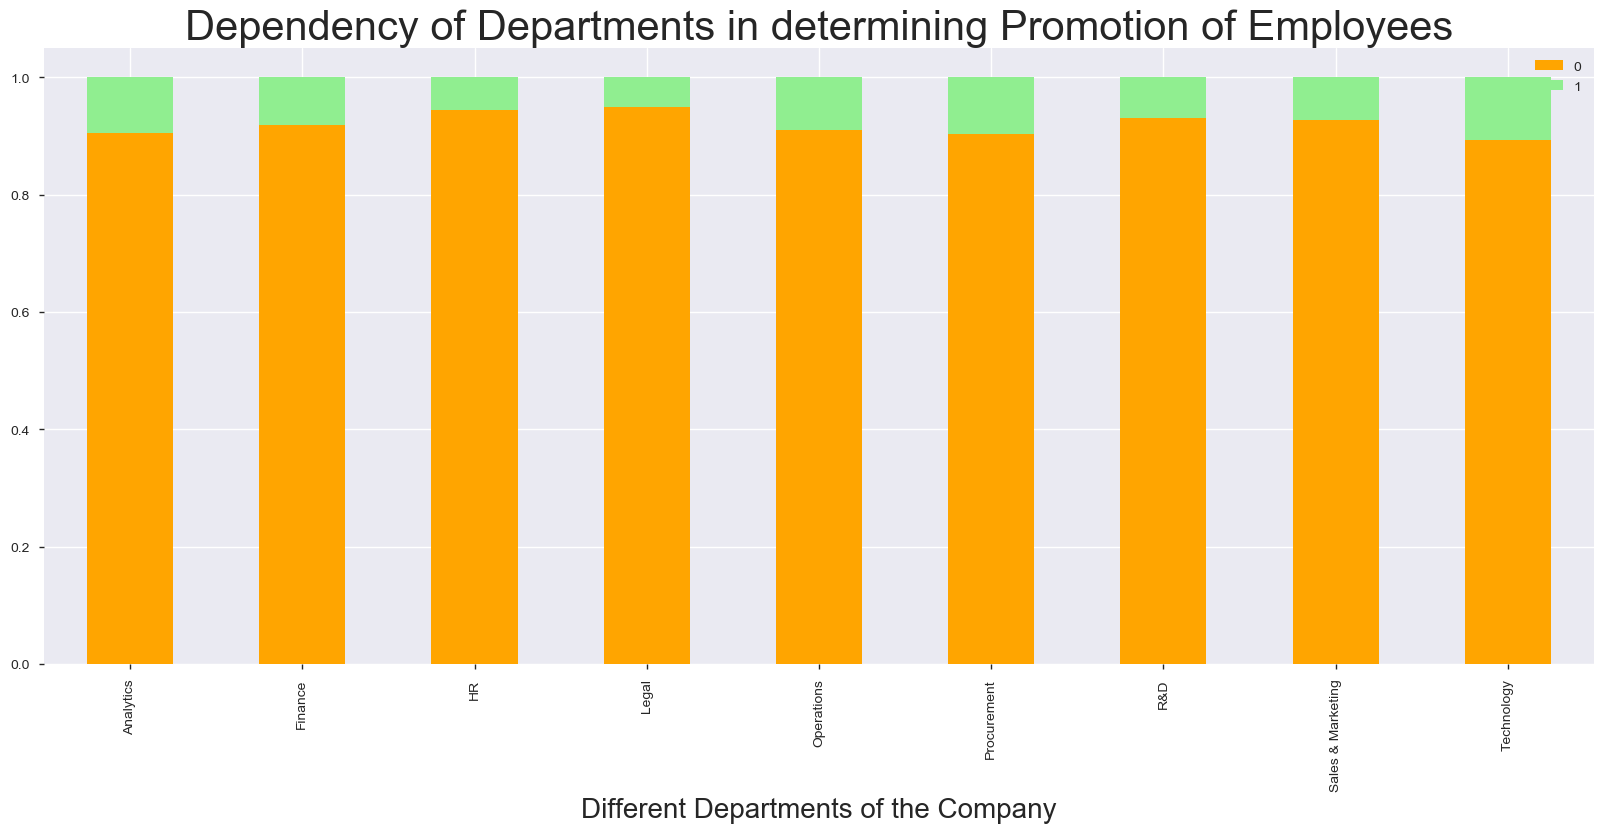

In [32]:
# checking which department got most number of promotions

data = pd.crosstab(train['department'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (20, 8), color = ['orange', 'lightgreen'])

plt.title('Dependency of Departments in determining Promotion of Employees', fontsize = 30)
plt.xlabel('Different Departments of the Company', fontsize = 20)
plt.legend()
plt.show()

Again, Each of the departments have equal no. of promotions showing an equal developement in each of the departments of the company.

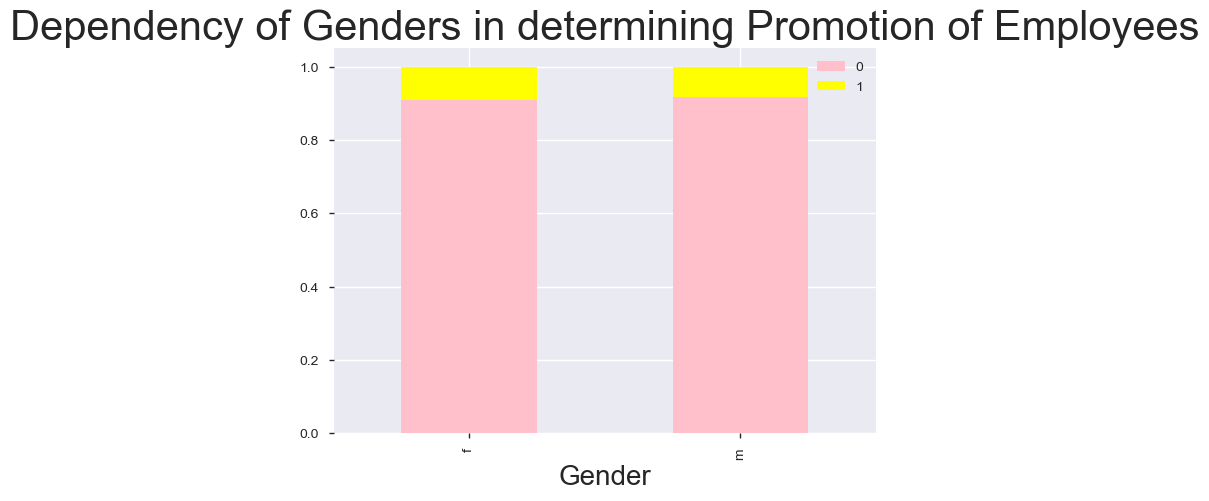

In [33]:
# checking dependency of gender over promotion

data = pd.crosstab(train['gender'], train['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (7, 5), color = ['pink', 'yellow'])

plt.title('Dependency of Genders in determining Promotion of Employees', fontsize = 30)
plt.xlabel('Gender', fontsize = 20)
plt.legend()
plt.show()

The above plot shows that there is no partiality between males and females in terms of promotion

Looking at attributes (EDA)
Can we make some inferences from EDA ?

Promotions are worst in Legal department (5.1%). 
Best promotions are in Technology department (10.7%).
Region 9 is worst (1.9%) and region 4 is best (14.4%) in terms of promotions.
Although Master's & above has greater promotion percentage but difference is not much.
Employees having previous years rating greater than 5 will have better chances of promotion than others.
Employess having KPI greater than 80% has good chances of promotions (16%)
Employees winning awards are promoted more (44%)

In [34]:
for col in train.drop('is_promoted',axis=1).columns:
    if train[col].dtype == 'object' or train[col].nunique() < 10:
        xx = train.groupby(col)['is_promoted'].value_counts().unstack(1)
        per_not_promoted = xx.iloc[:, 0] *100/xx.apply(lambda x: x.sum(), axis=1)
        per_promoted = xx.iloc[:, 1]*100/xx.apply(lambda x: x.sum(), axis=1)
        xx['%_0'] = per_not_promoted
        xx['%_1'] = per_promoted
        display(xx)

is_promoted,0,1,%_0,%_1
department,,,,
Analytics,4840,512,90.433483,9.566517
Finance,2330,206,91.876972,8.123028
HR,2282,136,94.375517,5.624483
Legal,986,53,94.898941,5.101059
Operations,10325,1023,90.985196,9.014804
Procurement,6450,688,90.361446,9.638554
R&D,930,69,93.093093,6.906907
Sales & Marketing,15627,1213,92.796912,7.203088
Technology,6370,768,89.240684,10.759316


is_promoted,0,1,%_0,%_1
region,,,,
region_1,552,58,90.491803,9.508197
region_10,597,51,92.129630,7.870370
region_11,1241,74,94.372624,5.627376
region_12,467,33,93.400000,6.600000
region_13,2418,230,91.314199,8.685801
region_14,765,62,92.503023,7.496977
region_15,2586,222,92.094017,7.905983
region_16,1363,102,93.037543,6.962457
region_17,687,109,86.306533,13.693467


is_promoted,0,1,%_0,%_1
education,,,,
Bachelor's,33661,3008,91.796886,8.203114
Below Secondary,738,67,91.677019,8.322981
Master's & above,13454,1471,90.144054,9.855946


is_promoted,0,1,%_0,%_1
gender,,,,
f,14845,1467,91.006621,8.993379
m,35295,3201,91.684850,8.315150


is_promoted,0,1,%_0,%_1
recruitment_channel,,,,
other,27890,2556,91.604809,8.395191
referred,1004,138,87.915937,12.084063
sourcing,21246,1974,91.498708,8.501292


is_promoted,0,1,%_0,%_1
previous_year_rating,,,,
1.0,6135,88,98.585891,1.414109
2.0,4044,181,95.715976,4.284024
3.0,17263,1355,92.722097,7.277903
4.0,9093,784,92.062367,7.937633
5.0,9820,1921,83.638532,16.361468


is_promoted,0,1,%_0,%_1
KPIs_met >80%,,,,
0,34111,1406,96.041332,3.958668
1,16029,3262,83.090560,16.909440


is_promoted,0,1,%_0,%_1
awards_won?,,,,
0,49429,4109,92.325078,7.674922
1,711,559,55.984252,44.015748


In [35]:
train['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

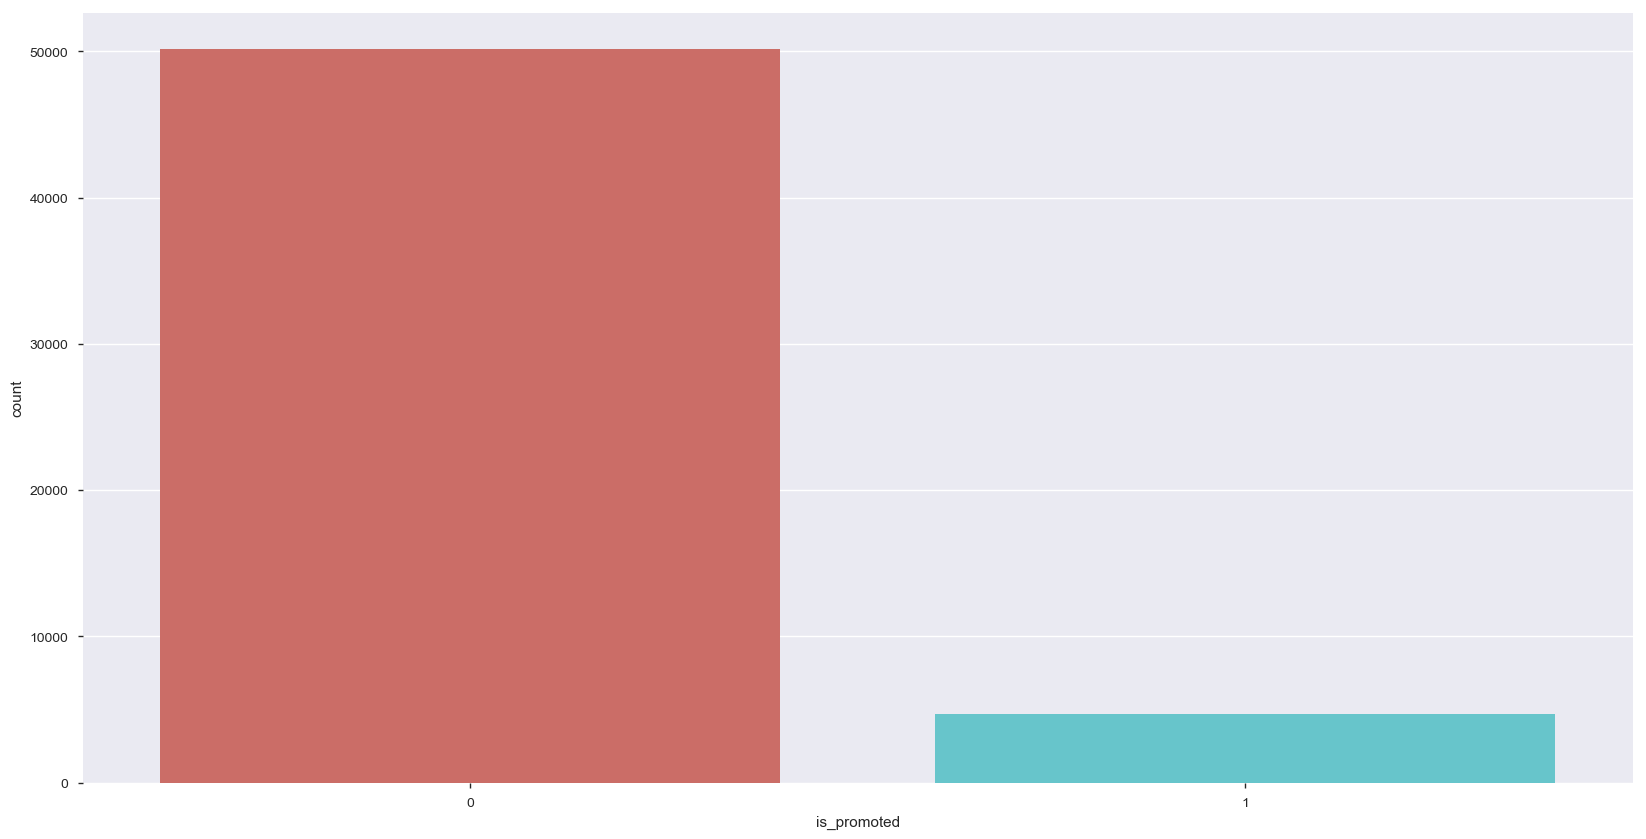

<Figure size 2000x1000 with 0 Axes>

In [36]:
sns.countplot(x='is_promoted',data=train, palette='hls')
plt.show()
plt.savefig('count_plot')

In [37]:
train.groupby('is_promoted').mean()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
is_promoted,,,,,,,,
0,39187.520423,1.257639,34.844037,3.267911,5.879398,0.319685,0.014180,62.647686
1,39285.092331,1.203299,34.372965,3.986140,5.716367,0.698800,0.119751,71.325193


Data Pre-processing

In [38]:
# Replace the '?'s with NaN
train = train.replace('?', np.NaN)

# Impute the missing values with mean imputation
train.fillna(train.mean(), inplace=True)

# Iterate over each column of cc_apps
train = train.fillna(method='ffill')

Drop column

In [39]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [40]:
# Checking the attribute names
pd.DataFrame(train.columns)

,0
0,employee_id
1,department
2,region
3,education
4,gender
5,recruitment_channel
6,no_of_trainings
7,age
8,previous_year_rating
9,length_of_service


defining the test set

In [41]:
# splitting the train set into dependent and independent sets

X = train.iloc[:,1:-1]
y = train.iloc[:, -1]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (54808, 12)
Shape of y: (54808,)


In [42]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Iterate over all the values of each column and extract their dtypes
for col in X:
    # Compare if the dtype is object
    if X[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
         X[col]=le.fit_transform(X[col])
X.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,7,31,2,0,2,1,35,5.0,8,1,0,49
1,4,14,0,1,0,1,30,5.0,4,0,0,60
2,7,10,0,1,2,1,34,3.0,7,0,0,50
3,7,15,0,1,0,2,39,1.0,10,0,0,50
4,8,18,0,1,0,1,45,3.0,2,0,0,73


In [57]:
X.to_csv('clean.csv')

In [43]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Iterate over all the values of each column and extract their dtypes
for col in y:
    # Compare if the dtype is object
    if y[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
         y[col]=le.fit_transform(y[col])
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_promoted, dtype: int64

In [44]:
# splitting x and y into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (41106, 12)
Shape of X_test:  (13702, 12)
Shape of y_train:  (41106,)
Shape of y_test:  (13702,)


In [45]:
# standard scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [46]:
# applying pca

from sklearn.decomposition import PCA

pca = PCA(n_components = None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [47]:
#Modelling

#Random Forest Classifer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

print("Training Accuracy :", rfc.score(X_train, y_train))

print("Validation Accuracy :", rfc.score(X_test, y_test))

cm = confusion_matrix(y_test, rfc_pred)
print(cm)

cr = classification_report(y_test, rfc_pred)
print(cr)

apc = average_precision_score(y_test, rfc_pred)
print("Average Precision Score :", apc)

Training Accuracy : 0.9895149126648178
Validation Accuracy : 0.9233688512625894
[[12432   116]
 [  934   220]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12548
           1       0.65      0.19      0.30      1154

    accuracy                           0.92     13702
   macro avg       0.79      0.59      0.63     13702
weighted avg       0.91      0.92      0.90     13702

Average Precision Score : 0.19298985791081597


In [48]:
#Xg-Boost Classifier

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

print("Training Accuracy :", xgb.score(X_train, y_train))

print("Validation Accuracy :", xgb.score(X_test, y_test))

cm = confusion_matrix(y_test, xgb_pred)
print(cm)

cr = classification_report(y_test, xgb_pred)
print(cr)

apc = average_precision_score(y_test, xgb_pred)
print("Average Precision Score :", apc)

Training Accuracy : 0.9234175059602004
Validation Accuracy : 0.9233688512625894
[[12503    45]
 [ 1005   149]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     12548
           1       0.77      0.13      0.22      1154

    accuracy                           0.92     13702
   macro avg       0.85      0.56      0.59     13702
weighted avg       0.91      0.92      0.90     13702

Average Precision Score : 0.17251345953419034


In [49]:
#Light Gradient Boosting Classifier

from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

lgb_pred = lgb.predict(X_test)

print("Training Accuracy :", lgb.score(X_train, y_train))

print("Validation Accuracy :", lgb.score(X_test, y_test))

cm = confusion_matrix(y_test, lgb_pred)
print(cm)

cr = classification_report(y_test, lgb_pred)
print(cr)

apc = average_precision_score(y_test, lgb_pred)
print("Average Precision Score :", apc)

Training Accuracy : 0.935118960735659
Validation Accuracy : 0.928842504743833
[[12493    55]
 [  920   234]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     12548
           1       0.81      0.20      0.32      1154

    accuracy                           0.93     13702
   macro avg       0.87      0.60      0.64     13702
weighted avg       0.92      0.93      0.91     13702

Average Precision Score : 0.23132643593348173


In [50]:
#Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

etc_pred = etc.predict(X_test)

print("Training Accuracy :", etc.score(X_train, y_train))

print("Validation Accuracy :", etc.score(X_test, y_test))

cm = confusion_matrix(y_test, etc_pred)
print(cm)

cr = classification_report(y_test, etc_pred)
print(cr)

apc = average_precision_score(y_test, etc_pred)
print("Average Precision Score :", apc)

Training Accuracy : 0.9997567265119447
Validation Accuracy : 0.9205225514523427
[[12386   162]
 [  927   227]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12548
           1       0.58      0.20      0.29      1154

    accuracy                           0.92     13702
   macro avg       0.76      0.59      0.63     13702
weighted avg       0.90      0.92      0.90     13702

Average Precision Score : 0.18244230818052815


In [51]:
#Cat Boost Classifier
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(learning_rate = 0.004, early_stopping_rounds = 100)
cbc.fit(X_train, y_train)

cbc_pred = cbc.predict(X_test)

print("Training Accuracy :", rfc.score(X_train, y_train))

print("Validation Accuracy :", rfc.score(X_test, y_test))

cm = confusion_matrix(y_test, cbc_pred)
print(cm)

cr = classification_report(y_test, cbc_pred)
print(cr)

apc = average_precision_score(y_test, cbc_pred)
print("Average Precision Score :", apc)

0:	learn: 0.6882431	total: 232ms	remaining: 3m 52s
1:	learn: 0.6832056	total: 358ms	remaining: 2m 58s
2:	learn: 0.6784370	total: 516ms	remaining: 2m 51s
3:	learn: 0.6734270	total: 665ms	remaining: 2m 45s
4:	learn: 0.6686779	total: 812ms	remaining: 2m 41s
5:	learn: 0.6635952	total: 958ms	remaining: 2m 38s
6:	learn: 0.6587889	total: 1.15s	remaining: 2m 43s
7:	learn: 0.6543678	total: 1.29s	remaining: 2m 40s
8:	learn: 0.6502168	total: 1.46s	remaining: 2m 40s
9:	learn: 0.6456740	total: 1.64s	remaining: 2m 42s
10:	learn: 0.6413886	total: 1.82s	remaining: 2m 43s
11:	learn: 0.6367246	total: 2s	remaining: 2m 44s
12:	learn: 0.6324191	total: 2.17s	remaining: 2m 44s
13:	learn: 0.6281166	total: 2.35s	remaining: 2m 45s
14:	learn: 0.6240835	total: 2.55s	remaining: 2m 47s
15:	learn: 0.6200555	total: 2.73s	remaining: 2m 47s
16:	learn: 0.6159216	total: 2.91s	remaining: 2m 48s
17:	learn: 0.6116876	total: 3.07s	remaining: 2m 47s
18:	learn: 0.6073769	total: 3.2s	remaining: 2m 45s
19:	learn: 0.6035590	total

In [52]:
#Stacking of models

# defining the stacked predictions

stacked_predictions = np.column_stack((rfc_pred, xgb_pred, etc_pred, lgb_pred, cbc_pred))

# specifyinng the meta model
meta_model = RandomForestClassifier()
meta_model.fit(stacked_predictions, y_test)

# final predictions
stacked_predictions = meta_model.predict(stacked_predictions)

cm = confusion_matrix(y_test, stacked_predictions)
print(cm)

cr = classification_report(y_test, stacked_predictions)
print(cr)

apc = average_precision_score(y_test, stacked_predictions)
print("Average Precision Score :", apc)

[[12499    49]
 [  918   236]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     12548
           1       0.83      0.20      0.33      1154

    accuracy                           0.93     13702
   macro avg       0.88      0.60      0.65     13702
weighted avg       0.92      0.93      0.91     13702

Average Precision Score : 0.23634289244361834


In [53]:
#Boosting the Model

boosted_predictions = rfc_pred*0.2 + xgb_pred*0.2 + lgb_pred*0.4 + etc_pred*0.3 + cbc_pred*0.3

apc = average_precision_score(y_test, boosted_predictions)
print("Average Precision Score :", apc)

Average Precision Score : 0.29052909160947576


In [54]:
# creating a dataframe with the employee id and their predicted promoted values{0, 1}

# submission = pd.DataFrame({'employee_id': emp_id,'is_promoted': boosted_predictions})

# submission.head()

# saving the submission file

#filename = 'submission.csv'
#submission.to_csv(filename, index = False)

#print("Saved File : ", filename)